In [1]:
import torch, torchvision
import torch.optim as optim

from bgan.cnnTrainer import CnnTrainer
from bgan.datasets import CIFAR10
from bgan.networkparts import layer13
from bgan.schedules import cosLr, sigmoidConsRamp

%matplotlib inline
%load_ext autoreload
%autoreload 2

## CNN Configuration

In [2]:
savedir = '/home/maf388/tb-experiments/rejectCnnFull/'
load_path = '/home/maf388/tb-experiments/rejectCnnFull/checkpoints/c.499.ckpt'
total_epochs = 500
opt_constr = lambda params, base_lr: optim.SGD(params, base_lr, .9, weight_decay=1e-4, nesterov=True)
lr_lambda = cosLr(total_epochs, 1)

config = {'base_lr':.1, 'amntLab':1, 
          'lab_BS':50, 'ul_BS':50, 'num_workers':2,
          'lr_lambda':lr_lambda, 'opt_constr':opt_constr,
          }

CNN = layer13(numClasses=10)
datasets = CIFAR10(aug=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainer = CnnTrainer(CNN, datasets, savedir, load_path, **config)

=> loading checkpoint '/home/maf388/tb-experiments/rejectCnnFull/checkpoints/c.499.ckpt'


In [ ]:
# trainer.train(total_epochs)
# trainer.save_checkpoint()

In [ ]:
trainer.getDevsetAccuracy()

In [ ]:
#trainer.constSWA(50, lr=1e-3)

In [ ]:
#trainer.CNN.load_state_dict(trainer.SWA.state_dict())
#trainer.getDevsetAccuracy()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from bgan.utils import to_var_gpu

In [5]:
trainer.CNN.train(False)
max_logits = np.zeros(10000)
i=0
for (x, y) in trainer.dev:
    x = to_var_gpu(x, volatile=True)
    bs = x.size()[0]
    max_logits[i:i+bs] = trainer.CNN(x).max(1)[0].cpu().data.numpy()
    i += bs

(array([  9.,  34.,  97., 194., 285., 348., 432., 511., 659., 726., 728.,
        814., 826., 873., 777., 681., 600., 468., 328., 237., 146., 109.,
         53.,  25.,  16.,   9.,   5.,   5.,   1.,   4.]),
 array([ 3.31941247,  4.73173648,  6.14406048,  7.55638449,  8.9687085 ,
        10.38103251, 11.79335651, 13.20568052, 14.61800453, 16.03032854,
        17.44265254, 18.85497655, 20.26730056, 21.67962457, 23.09194857,
        24.50427258, 25.91659659, 27.32892059, 28.7412446 , 30.15356861,
        31.56589262, 32.97821662, 34.39054063, 35.80286464, 37.21518865,
        38.62751265, 40.03983666, 41.45216067, 42.86448468, 44.27680868,
        45.68913269]),
 <a list of 30 Patch objects>)

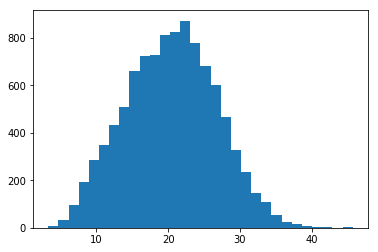

In [6]:
plt.hist(max_logits,bins=30)

In [ ]:
def reject(threshold):
    trainer.CNN.train(False)
    i=0
    accSum = 0
    for (x, y) in trainer.dev:
        x = to_var_gpu(x, volatile=True)
        y = to_var_gpu(y).cpu().data.numpy()
        max_logit = trainer.CNN(x).max(1)[0].cpu().data.numpy()
        pred = trainer.CNN(x).max(1)[1].cpu().data.numpy()
        accepted = max_logit>threshold
        accSum += (pred[accepted]==y[accepted]).sum()
        i += np.sum(accepted)
    return accSum/i, 1-i/10000

In [ ]:
thresholds = np.linspace(0,19,30)

In [ ]:
accs = np.zeros_like(thresholds)
reject_rates = np.zeros_like(thresholds)
for i, thresh in enumerate(thresholds):
    accs[i], reject_rates[i] = reject(thresh)

In [ ]:
plt.xlabel("Rejection Rate")
plt.ylabel("Test Error (%)")
plt.plot(reject_rates[:28], 100*(1-accs[:28]))

In [61]:
def stratAcc(threshold, bin_width):
    trainer.CNN.train(False)
    #i=0
    #accSum = 0
    acceptedAccs = []
    for (x, y) in trainer.dev:
        x = to_var_gpu(x, volatile=True)
        y = to_var_gpu(y).cpu().data.numpy()
        max_logit = trainer.CNN(x).max(1)[0].cpu().data.numpy()
        pred = trainer.CNN(x).max(1)[1].cpu().data.numpy()
        accepted = (max_logit>threshold)&(max_logit <= threshold + bin_width)
        if np.any(accepted):
            acceptedAccs.append((pred[accepted]==y[accepted]).astype(np.int64))
    if acceptedAccs != []:
        acceptedAccs = np.concatenate(acceptedAccs).ravel()
    count = len(acceptedAccs)
    if count:
#         print(acceptedAccs)
#         print(acceptedAccs.shape)
        std = acceptedAccs.std()
        acc = acceptedAccs.mean()
        #print(std)
    else:
        std = 0
        acc = 0
    return acc, count, std

In [62]:
thresh2 = np.linspace(2,40,30)
bin_width = thresh2[1]-thresh2[0]
accs2 = np.zeros_like(thresh2)
counts = np.zeros_like(thresh2)
stds = np.zeros_like(thresh2)

In [63]:
for i, thresh in enumerate(thresh2):
    accs2[i], counts[i], stds[i] = stratAcc(thresh, bin_width)

[  0.   7.  26.  84. 157. 218. 318. 347. 445. 526. 624. 685. 686. 762.
 761. 831. 692. 675. 581. 479. 349. 258. 184. 120.  84.  42.  20.  16.
   7.   6.]


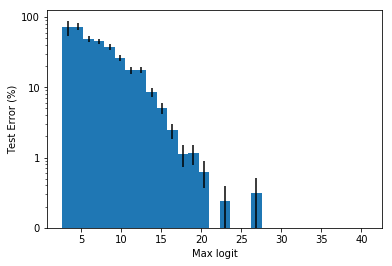

In [79]:
print(counts)
from matplotlib.ticker import ScalarFormatter
fig, ax = plt.subplots()

y = 100*(1-accs2)


ax.bar(thresh2[1:], y[1:], bin_width, yerr=100*stds[1:]/np.sqrt(counts[1:]), bottom=.1)
ax.set_xlabel("Max logit")
ax.set_ylabel("Test Error (%)")
ax.set_yscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
plt.show()

[  0.   7.  26.  84. 157. 218. 318. 347. 445. 526. 624. 685. 686. 762.
 761. 831. 692. 675. 581. 479. 349. 258. 184. 120.  84.  42.  20.  16.
   7.   6.]


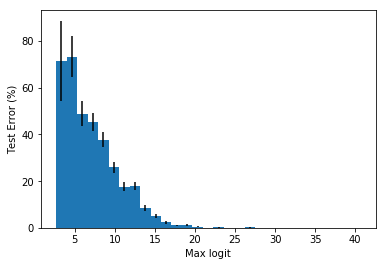

In [80]:
from matplotlib.ticker import ScalarFormatter
fig, ax = plt.subplots()

y = 100*(1-accs2)


ax.bar(thresh2[1:], y[1:], bin_width, yerr=100*stds[1:]/np.sqrt(counts[1:]), bottom=.1)
ax.set_xlabel("Max logit")
ax.set_ylabel("Test Error (%)")
plt.show()

In [124]:
import torch.nn.functional as F
trainer.CNN.train(False)
max_ps = np.zeros(10000)
i=0
for (x, y) in trainer.dev:
    x = to_var_gpu(x, volatile=True)
    bs = x.size()[0]
    max_ps[i:i+bs] = F.softmax(trainer.CNN(x),dim=1).max(1)[0].cpu().data.numpy()
    i += bs

(array([8.000e+00, 7.000e+00, 1.000e+01, 1.600e+01, 1.300e+01, 6.000e+00,
        1.100e+01, 8.000e+00, 1.200e+01, 1.900e+01, 1.900e+01, 1.200e+01,
        2.300e+01, 1.800e+01, 2.700e+01, 1.900e+01, 2.700e+01, 1.700e+01,
        2.400e+01, 2.600e+01, 3.000e+01, 3.100e+01, 4.200e+01, 4.700e+01,
        5.300e+01, 6.200e+01, 7.400e+01, 1.510e+02, 2.480e+02, 7.212e+03]),
 array([-9.84437876e-04, -9.51623280e-04, -9.18808684e-04, -8.85994088e-04,
        -8.53179492e-04, -8.20364897e-04, -7.87550301e-04, -7.54735705e-04,
        -7.21921109e-04, -6.89106513e-04, -6.56291917e-04, -6.23477321e-04,
        -5.90662726e-04, -5.57848130e-04, -5.25033534e-04, -4.92218938e-04,
        -4.59404342e-04, -4.26589746e-04, -3.93775150e-04, -3.60960555e-04,
        -3.28145959e-04, -2.95331363e-04, -2.62516767e-04, -2.29702171e-04,
        -1.96887575e-04, -1.64072979e-04, -1.31258383e-04, -9.84437876e-05,
        -6.56291917e-05, -3.28145959e-05,  0.00000000e+00]),
 <a list of 30 Patch objects>)

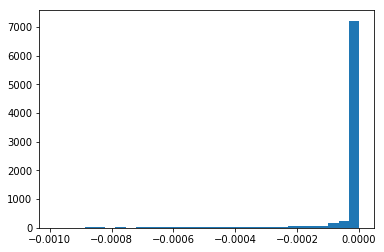

In [129]:
plt.hist(np.log(max_ps[max_ps>.999]),bins=30)

In [85]:
def stratAccP(threshold, bin_width):
    trainer.CNN.train(False)
    #i=0
    #accSum = 0
    acceptedAccs = []
    for (x, y) in trainer.dev:
        x = to_var_gpu(x, volatile=True)
        y = to_var_gpu(y).cpu().data.numpy()
        max_logit = F.softmax(trainer.CNN(x),dim=1).max(1)[0].cpu().data.numpy()
        pred = trainer.CNN(x).max(1)[1].cpu().data.numpy()
        accepted = (max_logit>threshold)&(max_logit <= threshold + bin_width)
        if np.any(accepted):
            acceptedAccs.append((pred[accepted]==y[accepted]).astype(np.int64))
    if acceptedAccs != []:
        acceptedAccs = np.concatenate(acceptedAccs).ravel()
    count = len(acceptedAccs)
    if count:
#         print(acceptedAccs)
#         print(acceptedAccs.shape)
        std = acceptedAccs.std()
        acc = acceptedAccs.mean()
        #print(std)
    else:
        std = 0
        acc = 0
    return acc, count, std

In [113]:
thresh3 = np.linspace(0.85,1,30)
bin_width3 = thresh3[1]-thresh3[0]
accs3 = np.zeros_like(thresh3)
counts3 = np.zeros_like(thresh3)
stds3 = np.zeros_like(thresh3)

In [118]:
for i, thresh in enumerate(thresh3):
    accs3[i], counts3[i], stds3[i] = stratAccP(thresh, bin_width3)

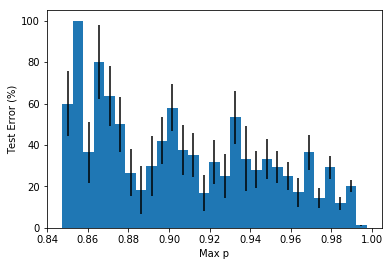

In [119]:
fig, ax = plt.subplots()

y = 100*(1-accs3)
mk = counts3>0

ax.bar(thresh3[mk], y[mk], bin_width3, yerr=100*stds3[mk]/np.sqrt(counts3[mk]))
ax.set_xlabel("Max p")
ax.set_ylabel("Test Error (%)")
ax.set_yscale('linear')
plt.show()

In [110]:
print(bin_width3)

0.005172413793103403


In [132]:
print(counts3.astype(int))

[  10    3   11    5   11   14   15   11   10   19   19   16   20   18
   19   16   15    9   25   24   34   40   29   33   55   65  109  174
 8721    0]


In [117]:
print(counts3.sum())

270349.0
